In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load dataset
df = pd.read_csv('bean1.csv')

# Drop categorical or string columns if present (assuming the last column is a label or non-numeric)
if not np.issubdtype(df.iloc[:, -1].dtype, np.number):
    df = df.iloc[:, :-6]

# Normalize the dataset
numeric_data = df.astype(np.float32)
normalized_data = (numeric_data - numeric_data.mean()) / numeric_data.std()

# Prepare DataLoader
tensor_data = torch.tensor(normalized_data.values)
dataset = TensorDataset(tensor_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Model, optimizer
input_dim = numeric_data.shape[1]
latent_dim = 2  # Adjust based on complexity
model = VAE(input_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in dataloader:
        x = batch[0]
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {train_loss/len(dataloader)}")

# Generating synthetic data
model.eval()
with torch.no_grad():
    z = torch.randn(500, latent_dim)  # Generate 100 random latent points
    synthetic_data = model.decode(z).numpy()
    synthetic_data = synthetic_data * numeric_data.std().values + numeric_data.mean().values

# Save synthetic data to CSV
synthetic_df = pd.DataFrame(synthetic_data, columns=numeric_data.columns)
synthetic_df.to_csv('synthetic_data_1.csv', index=False)

print("Synthetic data saved to 'synthetic_data_1.csv'")


Epoch 1, Loss: 1.0029471516609192
Epoch 2, Loss: 0.9950745403766632
Epoch 3, Loss: 1.0084624290466309
Epoch 4, Loss: 1.0615127086639404
Epoch 5, Loss: 0.9818432927131653
Epoch 6, Loss: 0.9649025201797485
Epoch 7, Loss: 0.9672795236110687
Epoch 8, Loss: 0.9667885899543762
Epoch 9, Loss: 0.9124702215194702
Epoch 10, Loss: 0.9367709755897522
Epoch 11, Loss: 0.9880442023277283
Epoch 12, Loss: 0.9594157934188843
Epoch 13, Loss: 0.9649598896503448
Epoch 14, Loss: 0.9804293215274811
Epoch 15, Loss: 0.9652770161628723
Epoch 16, Loss: 0.938050389289856
Epoch 17, Loss: 1.0407028794288635
Epoch 18, Loss: 0.9422126412391663
Epoch 19, Loss: 0.9434295296669006
Epoch 20, Loss: 1.008013665676117
Epoch 21, Loss: 0.9841131865978241
Epoch 22, Loss: 0.9379079937934875
Epoch 23, Loss: 0.9355760514736176
Epoch 24, Loss: 1.0622023940086365
Epoch 25, Loss: 0.9510548710823059
Epoch 26, Loss: 0.9948028922080994
Epoch 27, Loss: 0.951397716999054
Epoch 28, Loss: 0.9473723769187927
Epoch 29, Loss: 0.89720189571380

Epoch 1, Loss: 3.3596
Epoch 2, Loss: 2.8512
Epoch 3, Loss: 2.4863
Epoch 4, Loss: 2.0521
Epoch 5, Loss: 1.9063
Epoch 6, Loss: 1.5494
Epoch 7, Loss: 1.4555
Epoch 8, Loss: 1.3722
Epoch 9, Loss: 1.1857
Epoch 10, Loss: 1.0971
Epoch 11, Loss: 0.9866
Epoch 12, Loss: 1.0297
Epoch 13, Loss: 0.9711
Epoch 14, Loss: 1.0380
Epoch 15, Loss: 1.0147
Epoch 16, Loss: 0.9994
Epoch 17, Loss: 1.0972
Epoch 18, Loss: 1.0421
Epoch 19, Loss: 0.9864
Epoch 20, Loss: 1.0381
Epoch 21, Loss: 0.9473
Epoch 22, Loss: 0.9899
Epoch 23, Loss: 1.0331
Epoch 24, Loss: 1.0220
Epoch 25, Loss: 1.0615
Epoch 26, Loss: 0.9512
Epoch 27, Loss: 0.9713
Epoch 28, Loss: 0.8797
Epoch 29, Loss: 0.9239
Epoch 30, Loss: 0.8910
Epoch 31, Loss: 1.0130
Epoch 32, Loss: 0.9851
Epoch 33, Loss: 0.9793
Epoch 34, Loss: 0.9446
Epoch 35, Loss: 0.9541
Epoch 36, Loss: 0.9538
Epoch 37, Loss: 0.9580
Epoch 38, Loss: 1.1296
Epoch 39, Loss: 1.0513
Epoch 40, Loss: 0.9002
Epoch 41, Loss: 0.9402
Epoch 42, Loss: 0.8639
Epoch 43, Loss: 1.0139
Epoch 44, Loss: 1.07

Epoch 347, Loss: 0.9612
Epoch 348, Loss: 0.9574
Epoch 349, Loss: 0.9434
Epoch 350, Loss: 1.0104
Epoch 351, Loss: 1.0606
Epoch 352, Loss: 0.9427
Epoch 353, Loss: 1.1281
Epoch 354, Loss: 1.0025
Epoch 355, Loss: 0.9471
Epoch 356, Loss: 0.9934
Epoch 357, Loss: 0.9538
Epoch 358, Loss: 0.9615
Epoch 359, Loss: 0.9554
Epoch 360, Loss: 0.9581
Epoch 361, Loss: 0.8741
Epoch 362, Loss: 1.0078
Epoch 363, Loss: 0.9241
Epoch 364, Loss: 0.9985
Epoch 365, Loss: 1.0426
Epoch 366, Loss: 0.8816
Epoch 367, Loss: 1.0443
Epoch 368, Loss: 0.9949
Epoch 369, Loss: 1.0396
Epoch 370, Loss: 0.9323
Epoch 371, Loss: 0.9678
Epoch 372, Loss: 0.9667
Epoch 373, Loss: 1.0224
Epoch 374, Loss: 0.9368
Epoch 375, Loss: 0.9745
Epoch 376, Loss: 1.0118
Epoch 377, Loss: 0.9741
Epoch 378, Loss: 0.9242
Epoch 379, Loss: 1.0605
Epoch 380, Loss: 0.9974
Epoch 381, Loss: 0.8827
Epoch 382, Loss: 0.9387
Epoch 383, Loss: 0.9275
Epoch 384, Loss: 0.9451
Epoch 385, Loss: 0.9886
Epoch 386, Loss: 0.9582
Epoch 387, Loss: 0.8717
Epoch 388, Loss:

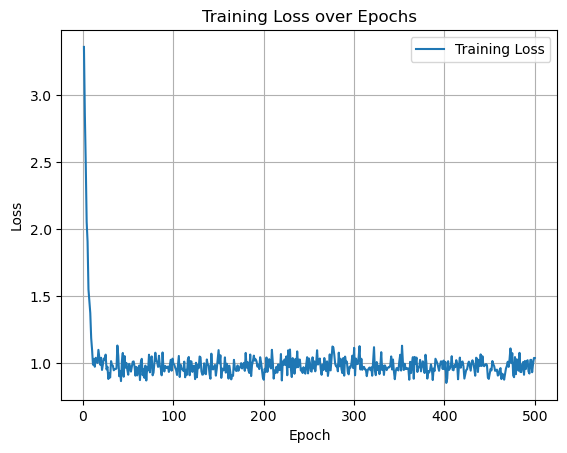

,28395,610.291,208.178116708527,173.888747041636,1.19719142411602,0.549812187138347,28715,190.141097274511,0.763922518159806,0.988855998607,0.958027126250128,0.913357754795763,0.00733150613518321,0.00314728916733569,0.834222388245556,0.998723889013168
0,31431.189453,646.495544,217.276672,184.552521,1.178773,0.519252,31786.060547,200.03685,0.772383,0.988881,0.945467,0.921394,0.006913,0.003079,0.849438,0.998575
1,31431.189453,646.495544,217.276672,184.552521,1.178773,0.519252,31786.060547,200.03685,0.772383,0.988881,0.945467,0.921394,0.006913,0.003079,0.849438,0.998575
2,31431.189453,646.495544,217.276672,184.552521,1.178773,0.519252,31786.060547,200.03685,0.772383,0.988881,0.945467,0.921394,0.006913,0.003079,0.849438,0.998575
3,31431.189453,646.495544,217.276672,184.552521,1.178773,0.519252,31786.060547,200.03685,0.772383,0.988881,0.945467,0.921394,0.006913,0.003079,0.849438,0.998575
4,31431.189453,646.495544,217.276672,184.552521,1.178773,0.519252,31786.060547,200.03685,0.772383,0.988881,0.945467,0.921394,0.006913,0.003079,0.849438,0.998575


In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('bean1.csv')

# Drop categorical or string columns if present (assuming the last 6 columns are non-numeric or labels)
df = df.iloc[:, :-1]

# Normalize the dataset
numeric_data = df.astype(np.float32)
normalized_data = (numeric_data - numeric_data.mean()) / numeric_data.std()

# Prepare DataLoader
tensor_data = torch.tensor(normalized_data.values)
dataset = TensorDataset(tensor_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Model, optimizer
input_dim = numeric_data.shape[1]
latent_dim = 20
model = VAE(input_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 500
train_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in dataloader:
        x = batch[0]
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    average_loss = train_loss / len(dataloader)
    train_losses.append(average_loss)
    print(f"Epoch {epoch+1}, Loss: {average_loss:.4f}")

# Save model
torch.save(model.state_dict(), 'vae_model.pth')

# Plot training loss
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Generate synthetic data
model.eval()
with torch.no_grad():
    z = torch.randn(500, latent_dim)
    synthetic_data = model.decode(z).numpy()
    synthetic_data = synthetic_data * numeric_data.std().values + numeric_data.mean().values

# Save synthetic data
synthetic_df = pd.DataFrame(synthetic_data, columns=numeric_data.columns)
synthetic_df.to_csv('synthetic_data_1.csv', index=False)
synthetic_df.head()
